# Libraries 

In [21]:
import os
import random
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import glob
import Bio

from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.internal_coords import *
from Bio.PDB import NeighborSearch
from Bio.PDB.Polypeptide import PPBuilder
from Bio.PDB import parse_pdb_header
from Bio.PDB import Selection

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import matplotlib.lines as mlines
from jinja2.async_utils import auto_to_list
from mpl_toolkits.mplot3d import Axes3D

import protein_parser
from protein_parser import aa_info_dict

## Reading PDB files and protein info

In [22]:
parser=PDBParser(PERMISSIVE=1)

structure_id='test_protein'
#filename='/Users/alexchilton/Downloads/archive/train/AF-A0A0H2UPE1-F1-model_v4.pdb'
filename='/Users/alexchilton/Downloads/archive/train/AF-D0ZA02-F1-model_v4.pdb'

structure=parser.get_structure(structure_id, filename)

In [23]:
def get_aa_info_dict(csv_file_path = 'aa_mass_letter.csv'):
    """
    Reads the amino acid information from a CSV file and returns it as a dictionary.

    Parameters:
    csv_file_path (str): Path to the CSV file containing amino acid information.

    Returns:
    dict: Dictionary with amino acid information indexed by the 'Abbrev.' column.
    """
    aa_info = pd.read_csv(csv_file_path)
    aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
    return aa_info_dict


In [24]:
def get_aa_info_dict_short(csv_file_path = 'aa_mass_letter.csv'):
    """
    Reads the amino acid information from a CSV file and returns it as a dictionary.

    Parameters:
    csv_file_path (str): Path to the CSV file containing amino acid information.

    Returns:
    dict: Dictionary with amino acid information indexed by the 'Abbrev.' column.
    """
    aa_info = pd.read_csv(csv_file_path)
    aa_info_dict = aa_info.set_index('Short').to_dict(orient='index')
    return aa_info_dict

#

In [25]:
aa_info_dict = get_aa_info_dict('aa_mass_letter.csv')
aa_info_dict_short = get_aa_info_dict_short('aa_mass_letter.csv')

In [26]:
def get_residue_info(res_name, aa_info_dict):
    """
    Retrieves the amino acid letter for a given residue if it exists in the aa_info_dict.

    Parameters:
    residue (Bio.PDB.Residue): The residue object from which to extract the name.
    aa_info_dict (dict): Dictionary with amino acid information indexed by residue names.

    Returns:
    str: The amino acid letter if found, otherwise None.
    """
    
    if res_name in aa_info_dict:
        return aa_info_dict[res_name]['Short']
    else:
        print(f"Residue {res_name} not in amino acid info dictionary.")
        return None

In [27]:
def process_residue(residue, res_name, aa_info_dict, c_alpha_matrix):
    """
    Processes a residue to extract C-alpha coordinates and amino acid information,
    and appends them to the c_alpha_matrix.

    Parameters:
    residue (Bio.PDB.Residue): The residue object to process.
    aa_info_dict (dict): Dictionary with amino acid information indexed by residue names.
    c_alpha_matrix (list): List to store the C-alpha information.

    Returns:
    None
    """
    if 'CA' in residue:
        # Get C-alpha coordinates
        ca_atom = residue['CA']
        x, y, z = ca_atom.get_coord()
        print(x, y, z)
        # Append to the matrix
        c_alpha_matrix.append([
            x, y, z,                         # 3D coordinates
            aa_info_dict[res_name]['Short'], # Amino acid letter
            aa_info_dict[res_name]['Avg. mass (Da)']  # Mass info
        ])
    else:
        print(f"No C-alpha atom found for residue {res_name} in chain {residue.parent.id}")

In [28]:
def create_c_alpha_dataframe(c_alpha_matrix):
    """
    Converts the C-alpha matrix into a DataFrame and prints it or a debug message.

    Parameters:
    c_alpha_matrix (list): List containing C-alpha information.

    Returns:
    pd.DataFrame: DataFrame containing the C-alpha information.
    """
    # Convert to DataFrame
    c_alpha_df = pd.DataFrame(c_alpha_matrix, columns=["X", "Y", "Z", "AA", "Mass"])

    # Show DataFrame or debug message
    if c_alpha_df.empty:
        print("C-alpha DataFrame is empty. Check residue names or PDB file.")
    else:
        print(c_alpha_df)
    
    return c_alpha_df


In [29]:
def extract_c_alpha_info(structure, aa_info_dict):
    """
    Extracts C-alpha information from the structure and processes it into a DataFrame.

    Parameters:
    structure (Bio.PDB.Structure): The protein structure to process.
    aa_info_dict (dict): Dictionary with amino acid information indexed by residue names.

    Returns:
    pd.DataFrame: DataFrame containing the C-alpha information.
    """
    c_alpha_matrix = []

    # Extract all residues from the structure
    res_list = Selection.unfold_entities(structure, "R")

    # Loop through each residue in the structure
    for residue in res_list:
        res_name = residue.get_resname().title()
        aa_letter = get_residue_info(res_name, aa_info_dict)
        process_residue(residue, res_name, aa_info_dict, c_alpha_matrix)

    # Convert to DataFrame
    c_alpha_df = create_c_alpha_dataframe(c_alpha_matrix)
    return c_alpha_df

# Example usage
structure = parser.get_structure(structure_id, filename)
c_alpha_df = extract_c_alpha_info(structure, aa_info_dict)

23.388 -19.139 -9.239
24.634 -16.649 -6.582
23.024 -14.147 -4.186
19.519 -14.167 -2.949
20.762 -13.862 0.649
19.668 -11.361 3.355
16.327 -9.724 3.616
16.719 -9.261 7.389
13.28 -8.36 8.822
13.86 -5.581 11.427
10.486 -5.071 13.175
11.713 -2.695 15.909
9.228 -1.961 18.746
8.257 1.577 19.8
5.842 1.912 22.716
2.625 3.226 23.95
-0.584 4.884 24.331
-3.59 2.682 25.306
-7.165 3.84 25.0
-9.571 0.975 25.65
-13.052 0.839 24.235
-14.903 -2.485 24.369
-17.497 -4.055 21.981
-16.37 -5.119 18.463
-12.699 -5.547 17.434
-12.36 -1.845 16.48
-8.757 -1.413 15.326
-8.605 2.433 15.407
-5.875 5.115 15.554
-2.254 4.729 14.368
-1.011 1.527 12.713
2.084 0.174 10.968
2.217 -2.837 8.643
4.05 -4.914 6.074
2.696 -6.286 2.773
3.796 -8.618 -0.005
2.233 -9.678 -3.275
2.38 -9.994 -7.034
2.23 -7.255 -9.688
1.043 -8.061 -13.19
2.671 -5.428 -15.429
0.72 -4.279 -18.496
3.048 -2.492 -20.947
0.539 -1.046 -23.458
1.569 -0.543 -27.112
5.07 -0.724 -28.616
4.812 0.185 -32.296
8.285 -0.31 -33.703
9.325 2.489 -36.188
8.864 -0.156 -3

In [30]:
# Check if DataFrame has required data
if c_alpha_df.empty:
    print("C-alpha DataFrame is empty. Please ensure it contains data before plotting.")

### c-alpha pairwise distance heatmap

In [31]:
def calculate_pairwise_distances(coordinates):
    """
    Calculates the pairwise distances between C-alpha coordinates.

    Parameters:
    coordinates (np.ndarray): Array of C-alpha coordinates.

    Returns:
    np.ndarray: Distance matrix containing pairwise distances.
    """
    num_residues = len(coordinates)
    distance_matrix = np.zeros((num_residues, num_residues))
    for i in range(num_residues):
        for j in range(i, num_residues):
            dist = np.linalg.norm(coordinates[i] - coordinates[j])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist  # Symmetric matrix
    return distance_matrix


In [32]:
def plot_heatmap(distance_matrix, title="C-alpha Pairwise Distance Heatmap"):
    """
    Plots a heatmap for the given distance matrix.

    Parameters:
    distance_matrix (np.ndarray): The matrix containing pairwise distances.
    title (str): The title for the heatmap.

    Returns:
    None
    """
    plt.figure(figsize=(6, 6))
    sns.heatmap(distance_matrix, cmap="viridis", square=True)
    plt.title(title)
    plt.xlabel("Residue Index")
    plt.ylabel("Residue Index")
    plt.show()

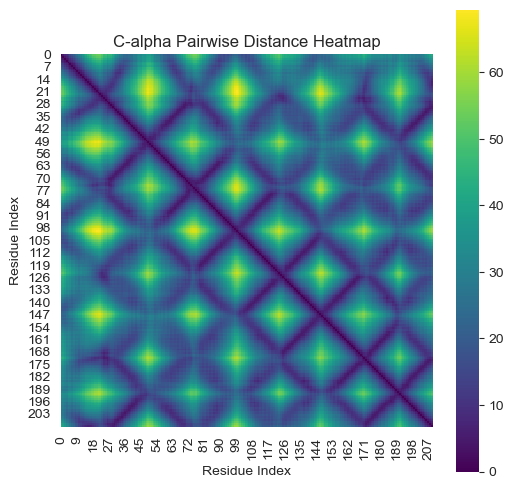

In [33]:
coordinates = c_alpha_df[['X', 'Y', 'Z']].values
distance_matrix = calculate_pairwise_distances(coordinates)

plot_heatmap(distance_matrix)


This new found informations can be included in the 3d structure for a better estimate

In [34]:
def encode_amino_acid_properties(aa_letters, aa_info_dict_short):
    """
    Encodes amino acid properties using a dictionary-based approach.

    Parameters:
    aa_letters (pd.Series): Series containing amino acid letters.
    aa_info_dict_short (dict): Dictionary with amino acid information indexed by short names.

    Returns:
    np.ndarray: Array of encoded amino acid properties.
    """
    encoded_features = []
    for aa in aa_letters:
        if aa in aa_info_dict_short:
            avg_mass = aa_info_dict_short[aa]['Avg. mass (Da)']
            # Include additional properties if available
            encoded_features.append([avg_mass])
        else:
            encoded_features.append([0])  # Adjust based on features you have

    # Convert encoded_features to numpy array
    return np.array(encoded_features)



In [35]:
def calculate_neighborhood_info(structure, neighborhood_radius=5.0):
    """
    Calculates neighborhood information for each C-alpha atom in the structure.

    Parameters:
    structure (Bio.PDB.Structure): The protein structure to process.
    neighborhood_radius (float): The radius to consider for neighborhood search in Å.

    Returns:
    list: A list containing neighborhood information for each C-alpha atom.
    """
    # Initialize NeighborSearch
    atom_list = [atom for atom in structure.get_atoms() if atom.name == 'CA']  # Use only C-alpha atoms
    neighbor_search = NeighborSearch(atom_list)

    # Calculate neighborhood information for each C-alpha atom
    neighborhood_info = []
    for res in structure.get_residues():
        if 'CA' in res:
            center = res['CA'].get_coord()
            # Find neighbors within the specified radius
            neighbors = neighbor_search.search(center, neighborhood_radius)
            # Exclude the residue itself and get neighbor distances
            distances = [np.linalg.norm(center - neighbor.get_coord()) for neighbor in neighbors if neighbor != res['CA']]

            # Neighborhood features
            avg_distance = np.mean(distances) if distances else 0  # Average distance to neighbors
            max_distance = np.max(distances) if distances else 0   # Max distance to neighbors
            count_neighbors = len(distances)                      # Count of neighbors within radius

            neighborhood_info.append([avg_distance, max_distance, count_neighbors])

    return neighborhood_info

# Example usage
neighborhood_info = calculate_neighborhood_info(structure)

In [36]:
def prepare_autoencoder_input(c_alpha_df, structure, aa_info_dict_short):
    """
    Prepares the input matrix for the autoencoder by combining 3D coordinates,
    encoded amino acid properties, and neighborhood information.

    Parameters:
    c_alpha_df (pd.DataFrame): DataFrame containing C-alpha information.
    structure (Bio.PDB.Structure): The protein structure to process.
    aa_info_dict_short (dict): Dictionary with amino acid information indexed by short names.

    Returns:
    pd.DataFrame: DataFrame containing the combined features for autoencoder input.
    """
    # Step 1: Extract 3D coordinates and amino acid information from c_alpha_df
    coords = c_alpha_df[['X', 'Y', 'Z']].values
    aa_letters = c_alpha_df['AA']

    # Step 2: Use dictionary-based encoding
    encoded_features = encode_amino_acid_properties(aa_letters, aa_info_dict_short)

    # Step 3: Compute neighborhood information
    neighborhood_info = calculate_neighborhood_info(structure)

    # Step 4: Combine all features into a matrix for autoencoder input
    autoencoder_input = np.hstack([
        coords,                 # 3D coordinates (X, Y, Z)
        encoded_features,       # Encoded amino acid properties from dictionary
        np.array(neighborhood_info)  # Neighborhood information
    ])

    # Convert to DataFrame for easy viewing (optional)
    columns = ['X', 'Y', 'Z', 'Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count']
    autoencoder_df = pd.DataFrame(autoencoder_input, columns=columns)

    return autoencoder_df

# Example usage
autoencoder_df = prepare_autoencoder_input(c_alpha_df, structure, aa_info_dict_short)

In [37]:
autoencoder_df

,X,Y,Z,Avg_Mass,Avg_Neighbor_Dist,Max_Neighbor_Dist,Neighbor_Count
0,23.388000,-19.139,-9.239000,149.20784,3.848671,3.848671,1.0
1,24.634001,-16.649,-6.582000,146.18934,3.834370,3.848671,2.0
2,23.024000,-14.147,-4.186000,89.09404,3.768501,3.820068,2.0
3,19.518999,-14.167,-2.949000,165.19184,3.767896,3.818858,2.0
4,20.761999,-13.862,0.649000,119.12034,3.831295,3.843732,2.0
...,...,...,...,...,...,...,...
205,-0.389000,-7.560,8.314000,117.14784,4.116339,4.713722,3.0
206,-1.093000,-4.358,10.287000,132.11904,3.878291,3.996533,3.0
207,-0.387000,-3.627,13.961000,181.19124,4.169213,4.836728,3.0
208,-2.372000,-0.894,15.827000,181.19124,4.153348,4.741887,4.0


In [38]:
print(autoencoder_df.shape)

(210, 7)


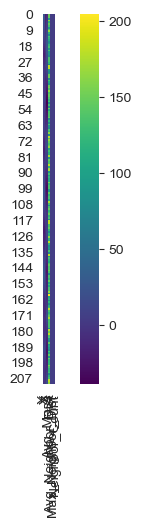

             0       1          2          3         4         5    6
0    23.388000 -19.139  -9.239000  149.20784  3.848671  3.848671  1.0
1    24.634001 -16.649  -6.582000  146.18934  3.834370  3.848671  2.0
2    23.024000 -14.147  -4.186000   89.09404  3.768501  3.820068  2.0
3    19.518999 -14.167  -2.949000  165.19184  3.767896  3.818858  2.0
4    20.761999 -13.862   0.649000  119.12034  3.831295  3.843732  2.0
..         ...     ...        ...        ...       ...       ...  ...
205  -0.389000  -7.560   8.314000  117.14784  4.116339  4.713722  3.0
206  -1.093000  -4.358  10.287000  132.11904  3.878291  3.996533  3.0
207  -0.387000  -3.627  13.961000  181.19124  4.169213  4.836728  3.0
208  -2.372000  -0.894  15.827000  181.19124  4.153348  4.741887  4.0
209  -0.804000   1.196  18.641001  165.19184  3.839964  3.839964  1.0

[210 rows x 7 columns]


In [39]:


# Assuming you have a heatmap plot
ax = sns.heatmap(autoencoder_df, cmap="viridis", square=True)
plt.show()

# Extract the data from the heatmap
heatmap_data = ax.collections[0].get_array().reshape(autoencoder_df.shape)

# Convert the extracted data to a DataFrame
extracted_df = pd.DataFrame(heatmap_data)
print(extracted_df)

In [40]:
def pad_dataframe(df, target_shape):
    """
    Pads the DataFrame to the target shape with zeros.

    Parameters:
    df (pd.DataFrame): The DataFrame to pad.
    target_shape (tuple): The target shape (rows, columns).

    Returns:
    pd.DataFrame: Padded DataFrame.
    """
    current_shape = df.shape
    if current_shape[0] >= target_shape[0] and current_shape[1] == target_shape[1]:
        return df  # No padding needed if already at or above target shape

    # Calculate the number of rows to add
    rows_to_add = target_shape[0] - current_shape[0]
    if rows_to_add > 0:
        # Create a DataFrame with the required number of rows filled with zeros
        padding_df = pd.DataFrame(np.zeros((rows_to_add, target_shape[1])), columns=df.columns)
        # Concatenate the original DataFrame with the padding DataFrame
        padded_df = pd.concat([df, padding_df], ignore_index=True)
    else:
        padded_df = df

    return padded_df


In [41]:
# Example usage
target_shape = (256, 7)
padded_autoencoder_df = pad_dataframe(autoencoder_df, target_shape)
print(padded_autoencoder_df.shape)  # Should print (256, 7)

(256, 7)


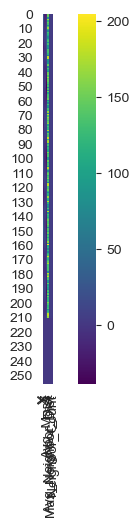

             0       1      2          3         4         5    6
0    23.388000 -19.139 -9.239  149.20784  3.848671  3.848671  1.0
1    24.634001 -16.649 -6.582  146.18934  3.834370  3.848671  2.0
2    23.024000 -14.147 -4.186   89.09404  3.768501  3.820068  2.0
3    19.518999 -14.167 -2.949  165.19184  3.767896  3.818858  2.0
4    20.761999 -13.862  0.649  119.12034  3.831295  3.843732  2.0
..         ...     ...    ...        ...       ...       ...  ...
251   0.000000   0.000  0.000    0.00000  0.000000  0.000000  0.0
252   0.000000   0.000  0.000    0.00000  0.000000  0.000000  0.0
253   0.000000   0.000  0.000    0.00000  0.000000  0.000000  0.0
254   0.000000   0.000  0.000    0.00000  0.000000  0.000000  0.0
255   0.000000   0.000  0.000    0.00000  0.000000  0.000000  0.0

[256 rows x 7 columns]


In [42]:
# Assuming you have a heatmap plot
ax = sns.heatmap(padded_autoencoder_df, cmap="viridis", square=True)
plt.show()

# Extract the data from the heatmap
heatmap_data = ax.collections[0].get_array().reshape(padded_autoencoder_df.shape)

# Convert the extracted data to a DataFrame
padded_extracted_df = pd.DataFrame(heatmap_data)
print(padded_extracted_df)